# Inference experiments `xyn`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torchmetrics.functional.text import word_error_rate
from torchmetrics.functional.text import char_error_rate
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

from src.models.carbune_module import CarbuneLitModule2
from src.models.carbune_module import LitModule1
from src.models.components.carbune2020_net import Carbune2020NetAttempt1
from src.utils.io import load_alphabet
from src.data.tokenisers import AlphabetMapper
from src.data.online_handwriting_datamodule import IAMOnDBDataModule
from src.data.online_handwriting_datasets import XournalPagewiseDataset
from src.data.online_handwriting_datasets import IAM_OnDB_Dataset
from src.data.online_handwriting_datasets import get_alphabet_from_dataset
from src.data.transforms import SimpleNormalise
from src.data.transforms import DictToTensor
from src.data.transforms import CharactersToIndices
from src.data.collate_functions import my_collator

In [3]:
BASE_PATH = Path('../logs/train/multiruns/2024-04-07_13-03-01/0')
CHECKPOINT_PATH = BASE_PATH / 'checkpoints/epoch000649.ckpt'

model = LitModule1.load_from_checkpoint(CHECKPOINT_PATH)

model.eval()

/localdisk/s1691089/venvs/carbune2020/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


LitModule1(
  (criterion): CTCLoss()
  (log_softmax): LogSoftmax(dim=2)
  (lstm_stack): LSTM(3, 64, num_layers=3, bidirectional=True)
  (linear): Linear(in_features=128, out_features=82, bias=True)
)

In [4]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location=lambda storage, loc: storage)
list(checkpoint.keys())

['epoch',
 'global_step',
 'pytorch-lightning_version',
 'state_dict',
 'loops',
 'callbacks',
 'optimizer_states',
 'lr_schedulers',
 'hparams_name',
 'hyper_parameters',
 'datamodule_hparams_name',
 'datamodule_hyper_parameters']

In [5]:
alphabet = load_alphabet(BASE_PATH / 'alphabet.json')
alphabet_mapper = AlphabetMapper( alphabet )
decoder = checkpoint['hyper_parameters']['decoder']

### Load data: From IAMOnDB

In [6]:
dm = IAMOnDBDataModule(**checkpoint['datamodule_hyper_parameters']) # This ensures correct DataModule as it's
                                                                    # consistent w/ checkpoint
dm.setup()
dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()

/localdisk/s1691089/venvs/carbune2020/lib/python3.10/site-packages/torch/utils/data/dataset.py:414: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


### Do inference on train and val datasets: IAMOnDB

In [7]:
df_data = {
    'name': [],
    'type': [],
    'value': [],
}

for name, dloader in { 'train': dl_train, 'val': dl_val }.items():
    for sample_batched in dloader:
        batch = sample_batched # Just a shortcut

        with torch.no_grad():
            log_softmax = model(sample_batched['ink'].to('cuda'))

        decoded_texts = decoder(log_softmax, alphabet_mapper)

        labels = batch['label_str']

        cer = char_error_rate(preds=decoded_texts, target=labels)
        wer = word_error_rate(preds=decoded_texts, target=labels)

        df_data['name'].append(name)
        df_data['type'].append('cer')
        df_data['value'].append(cer.item())

        df_data['name'].append(name)
        df_data['type'].append('wer')
        df_data['value'].append(wer.item())

df = pd.DataFrame.from_dict(df_data)

In [8]:
df.groupby(['name', 'type']).mean()

value
name  type          
train cer   0.052671
      wer   0.235968
val   cer   0.079784
      wer   0.316895

Reloading seems to work as this performance is roughly what I can observe in TenorBoard!

Strangely, the `train` values change (both cer and wer) when re-executing but not the `val` values. Question: also when re-executing the cell? Re question: I have checked manually that the reason is `shuffle=True` in train `DataLoader`. However, I don't know why the order of the same samples should influence a metric that takes in all samples. Strange! But probably not relevant for now.

### Load data: From XournalPagewise

This requires a custom built transform for the Dataset b/c one needs to use training alphabet!

In [9]:
# GET STANDALONE DATASET

# This is the one that I really want to use
dataset = XournalPagewiseDataset(
    Path('../data/datasets/2024-02-16-xournal_dataset.xoj'),
    transform=None,
)

# # This is the one to validate my code; result: yes it works! Just uncomment this to test it
# dataset = IAM_OnDB_Dataset(Path('../data/datasets/IAM-OnDB'), transform=None, limit=-1)

print(f'Number of samples in dataset: {len(dataset)}')

alphabet_inference = get_alphabet_from_dataset( dataset )
for letter in alphabet_inference: # Confirm that there are no OOV letters
    assert letter in alphabet

transform = transforms.Compose([
    SimpleNormalise(),
    DictToTensor(['x', 'y', 'n']),
    CharactersToIndices( alphabet ), # TODO: Why does it only work if CTI is last?
])

dataset.transform = transform

# GET STANDALONE DATALOADER

dl_inference = DataLoader(
    dataset=dataset,
    batch_size=64,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
    collate_fn=my_collator,
)

Number of samples in dataset: 4


### Do inference: XournalPagewise

In [10]:
df_data = {
    'name': [],
    'type': [],
    'value': [],
}

# for name, dloader in { 'train': dl_train_xp, 'val': dl_val_xp }.items():
for name, dloader in { 'inference': dl_inference, }.items():
    for sample_batched in dloader:
        batch = sample_batched # Just a shortcut

        with torch.no_grad():
            log_softmax = model(sample_batched['ink'].to('cuda'))

        decoded_texts = decoder(log_softmax, alphabet_mapper)

        labels = batch['label_str']

        for pred, truth in zip(decoded_texts, labels):
            print(f'"{pred}" <> "{truth}"')

        cer = char_error_rate(preds=decoded_texts, target=labels)
        wer = word_error_rate(preds=decoded_texts, target=labels)

        df_data['name'].append(name)
        df_data['type'].append('cer')
        df_data['value'].append(cer.item())

        df_data['name'].append(name)
        df_data['type'].append('wer')
        df_data['value'].append(wer.item())

df = pd.DataFrame.from_dict(df_data)

"I 1l Wicrdk!" <> "Hello World!"
"Lind a" <> "Linda"
"Martin" <> "Martin"
"efuk" <> "fun"


In [11]:
df.groupby(['name', 'type']).mean()

value
name      type          
inference cer   0.423077
          wer   1.200000

Both metrics improved a bit after using the correct (=training) alphabet.

However, the WER is still very bad; with CER being surprisingly good.

Nevertheless, I conclude that inference on my own written text in Xournal does **NOT** work!

Note that I confirmed the code to work by plugging in the IAM-OnDB dataset here which leads to reproducing the metrics as provided in `train` and `val` results reported above.

## Hypothesis: The two datasets are very different and hence the performance on X++ is so bad

Difference here means the input tensor as segment lengths.

Hence, investigate the lengths of the differences:

In [12]:
def get_segment_lengths(dataloaders: list) -> list:
    results = []

    for dataloader in dataloaders:
        for sample in dataloader:
            batch_size = sample['ink'].shape[1]
            for i_sample_in_batch in range(batch_size):
                length = sample['ink_lengths'][i_sample_in_batch]
                dx, dy = sample['ink'][:length, i_sample_in_batch, [0, 1]].T
                segment_lengths = np.sqrt((dx**2 + dy**2))
                results += segment_lengths.tolist()

    return np.array(results)

In [13]:
segment_lengths_IAM = get_segment_lengths([dl_train, dl_val])
segment_lengths_Xpp = get_segment_lengths([dl_inference,])

len(segment_lengths_IAM), len(segment_lengths_Xpp)

(7651716, 1771)

In [14]:
for sl in [segment_lengths_Xpp, segment_lengths_IAM]:
    print(sl.mean(), sl.std(), sl.max(), np.quantile(sl, 0.5), np.quantile(sl, 0.98))

0.03075740663339986 0.0582288076165338 0.8580945730209351 0.02013082057237625 0.10204081982374191
0.04772649997899526 0.08719070655718521 6.154927730560303 0.03245917335152626 0.3021262019872666


Remove outliers

In [15]:
segment_lengths_IAM_filtered = segment_lengths_IAM[ segment_lengths_IAM <= np.quantile(segment_lengths_IAM, 0.98) ]
segment_lengths_Xpp_filtered = segment_lengths_Xpp[ segment_lengths_Xpp <= np.quantile(segment_lengths_Xpp, 0.98) ]

for sl in [segment_lengths_Xpp_filtered, segment_lengths_IAM_filtered]:
    print(sl.mean(), sl.std(), sl.max(), np.quantile(sl, 0.5), np.quantile(sl, 0.98))

0.02406824852955798 0.016340708112571448 0.10204081982374191 0.02013082057237625 0.06732454672455779
0.037394472426955434 0.03228702894077389 0.3021261394023895 0.03190260007977486 0.11745930761098834


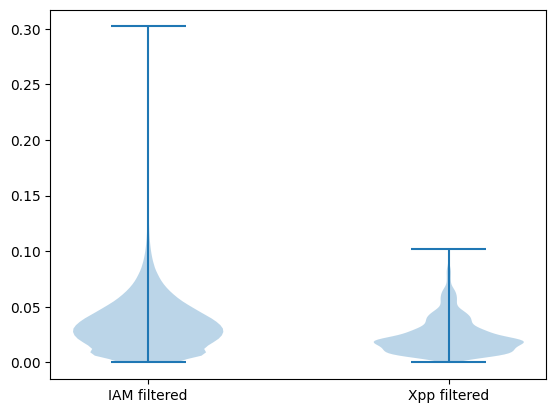

In [16]:
plt.figure()
plt.violinplot([segment_lengths_IAM_filtered, segment_lengths_Xpp_filtered])
plt.xticks(ticks=[1, 2], labels=['IAM filtered', 'Xpp filtered'])
plt.show()

The distributions do look quite different. This observation strenghtens my hypothesis that the segment lengths are just too different for the model to cope with.

This, unfortunately, can only be solved by resampling, which requires a time channel.

Next steps:
- Get some test data with `draw_and_store_sample.py` and repeat the notebook above including time channel.
- Also check if using full `Carbune2020` transform makes the two distributions (IAM and test data captured w/ script) equal b/c of linear resampling. This does not need any training, strictly speaking.